## WP5
### John D'Angelo
### University of Texas at Austin

#### 1) Biot coefficient determination

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

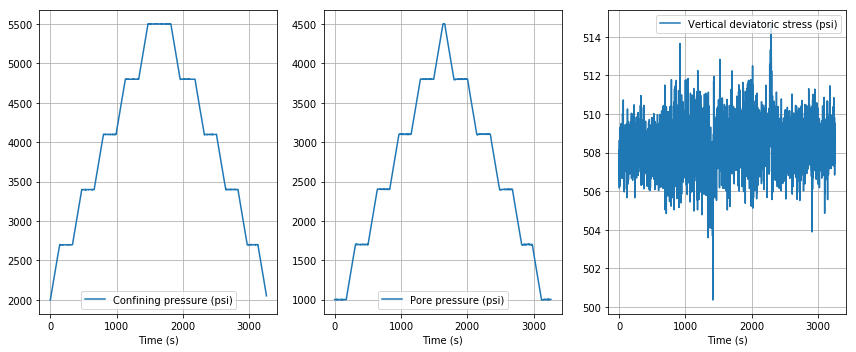

In [2]:
# part a, plot pressure and stresses as a funciton of time

# read file and check contents
filename = "BiotCoefficientExperiment.xlsx"
data =pd.read_excel(filename,skiprows=[0,1])
data['Vol strain (-)'] = data['Axial strain (-)'] + 2*data['Radial strain (-)']

# plot
fig,axs = plt.subplots(1,3,figsize=(12,5))
data.plot(x="Time (s)",y="Confining pressure (psi)",ax=axs[0])
axs[0].grid()
data.plot(x="Time (s)",y="Pore pressure (psi)",ax=axs[1])
axs[1].grid()
data.plot(x="Time (s)",y="Vertical deviatoric stress (psi)",ax=axs[2])
axs[2].grid()
plt.tight_layout()

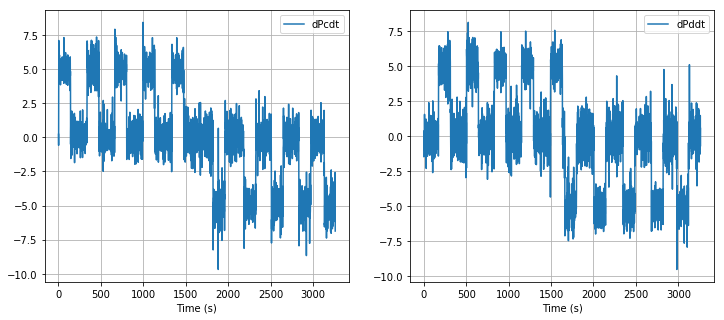

In [3]:
# part b, what is dPc/dt and dPp/dt? if permiability is 100 mD, and fluid is water,
# would the experiment be close to undrained loading

data["dPcdt"] = data['Confining pressure (psi)'].diff()/data['Time (s)'].diff()
data["dPddt"] = data['Pore pressure (psi)'].diff()/data['Time (s)'].diff()
# plot
fig,axs = plt.subplots(1,2,figsize=(12,5))
data.plot(x="Time (s)",y="dPcdt",ax=axs[0])
axs[0].grid()
data.plot(x="Time (s)",y="dPddt",ax=axs[1])
axs[1].grid()

In [4]:
# Get the average dPcdt and dPddt based on the above plot which show
# a loading time of about 140 [sec]
idx =data.index[data['Time (s)'] >= 140].tolist()[0]
t0=data['Time (s)'].iloc[0]
tn=data['Time (s)'].iloc[idx ]
Pc0=data['Confining pressure (psi)'].iloc[0]
Pcn=data['Confining pressure (psi)'].iloc[idx ]
Pd0=data['Pore pressure (psi)'].iloc[0]
Pdn=data['Pore pressure (psi)'].iloc[idx ]
print('dPcdt = ', np.round((Pcn-Pc0)/(tn-t0),2),'[psi/s]')
dPddt=np.round((Pdn-Pd0)/(tn-t0),2)
print('dPddt = ', dPddt,'[psi/s]')
print('Loading time: ', tn-t0)

dPcdt =  4.97 [psi/s]
dPddt =  -0.0 [psi/s]
Loading time:  140.7539999999999


In [5]:
permeability = 9.869e-14 #m^2
L = 0.0254 #characteristic drainage length, m
phi_o = 0.19 #initial porosity
alpha = 0.916 #Biot Coeffienct, calculated in part c
Kf = 2.2e9 #Bulk modulus of water, Pa
K = (427346.8*6894.76) # Bulk Modulus, also calcualted in part c, Pa
mu = 8.9e-4 #viscosity of water, Pa*s
M=1/((1-alpha)*(alpha-phi_o)/K + phi_o/Kf )
D_h = (permeability*M/mu)
T_ch = (L**2)/D_h #characteristic time, sec
print('T_ch: ',np.round(T_ch,4),' [sec]')
print('Experiment Loading time: ', 140,' [sec]')

T_ch:  0.0006  [sec]
Experiment Loading time:  140  [sec]


# To find how close we are to undrained loading, we compare the characteristic drainage time, T_ch, to the experimental loading time. Since the expeirment loading time is significantly larger than the characteristic drainage time, we can safely assume this was a drained loading situation.

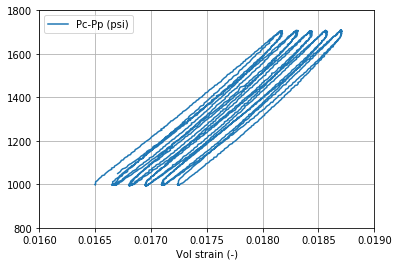

In [6]:
# part c, fit a straight line to the data to obtain a unique relationship 
# between eps_vol and sig_mean, and calculate bulk Biot coefficient alpha.

data['Pc-Pp (psi)'] = data['Confining pressure (psi)'] - data['Pore pressure (psi)']
ax = data.plot(x='Vol strain (-)',y="Pc-Pp (psi)")
ax.set_xlim([0.016,0.019])
ax.set_ylim([800,1800])
ax.grid()

Biot Coefficient is approximately: 0.91


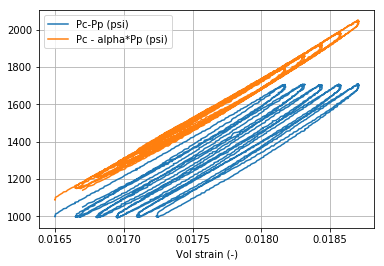

In [7]:
# Find alpha value that shifts the data into a straight line for Pc - alpha*Pp

# I see two ways to do this, method 1: guess and check
alpha = 0.91

print("Biot Coefficient is approximately: " + str(alpha))
data["Pc - alpha*Pp (psi)"] = data['Confining pressure (psi)'] - alpha*data['Pore pressure (psi)']
ax = data.plot(x='Vol strain (-)',y="Pc-Pp (psi)")
data.plot(x='Vol strain (-)',y="Pc - alpha*Pp (psi)",ax=ax)
ax.grid()

Calculted Biot Coefficient: 0.916


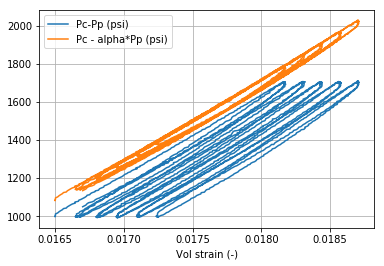

In [8]:
# method 2: fit a line through the data. Find the alpha value that minimizes the deviation around the line


from scipy import optimize

# There may be other ways to do this, but I chose to minimize the mean of all the standard deviations at each volumetric 
# strain level.
# This should result in the spreadout experimental results getting compacted into a line by the application of the 
# alpha term.
def minFun(alpha):
    data["Pc - alpha*Pp (psi)"] = data['Confining pressure (psi)']-data['Pore pressure (psi)']*alpha
    data['Rounded Vol strain (-)'] = data['Vol strain (-)'].apply(lambda x: np.round(x,4)) 
    error = np.mean(data.groupby('Rounded Vol strain (-)')['Pc - alpha*Pp (psi)'].apply(np.std))
    return error


alpha = optimize.minimize(minFun,0.3).x
ax = data.plot(x='Vol strain (-)',y="Pc-Pp (psi)")
data["Pc - alpha*Pp (psi)"] = data['Confining pressure (psi)'] - alpha*data['Pore pressure (psi)']
data.plot(x='Vol strain (-)',y="Pc - alpha*Pp (psi)",ax=ax)
ax.legend()
ax.grid()
print("Calculted Biot Coefficient: " + str(np.round(alpha[0],3)))


In [9]:
# Now fit a straight line to this data and find its slope to get the drained bulk modulus
from scipy import optimize

def fun(x, a,b):
    return a*x+b

K,bb = optimize.curve_fit(fun, data["Vol strain (-)"], data["Pc - alpha*Pp (psi)"])[0]
print("Drained bulk modulus is approximately: " + str(np.round(K,2)) + ' [psi]')

Drained bulk modulus is approximately: 427346.82 [psi]


Text(0,0.5,'Effective Stress (psi)')

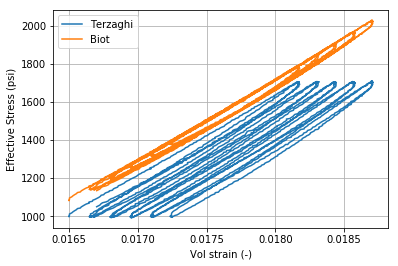

In [10]:
# part d, plot together volumetric strain with Terzaghi and Biot effective 
# Stresses

ax = data.plot(x="Vol strain (-)",y="Pc-Pp (psi)",label='Terzaghi')
data.plot(x="Vol strain (-)",y="Pc - alpha*Pp (psi)",ax=ax,label='Biot')
ax.grid()
ax.set_ylabel("Effective Stress (psi)")

#### 2) Depletion stress path

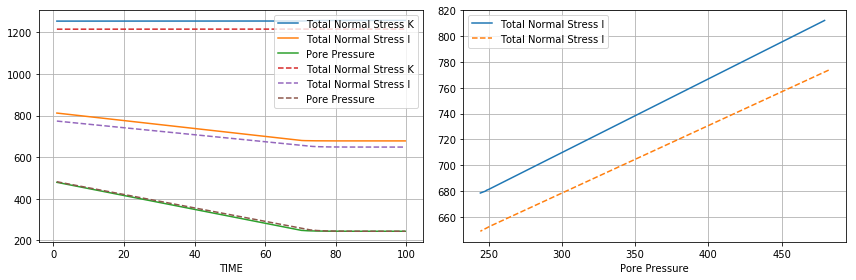

In [11]:
# CMG Analysis
# In order to have everything in one place, I ran the two simulations in CMG Geomechanics Software Package and then exported
# the results to excel.
# Here I will pull those results and plot them. Please note that the results
# have been manicured to exclude the initial data (time =0) and the last few
# datapoints were the stresses drop to 0.

# The initial boundary condition in each direction for both simulations
# was zero displacement.

# Simulation 1, Default Biot Coefficient
sim1Name = "production1_Results.xlsx"
data1 = pd.read_excel(sim1Name)

# Simulation 2, Calculated Biot Coefficient
sim2Name = "productionExp_Results.xlsx"
data2 = pd.read_excel(sim2Name)

# Plot results
fig,ax = plt.subplots(1,2,figsize=(12,4))
warnings.filterwarnings('ignore')
data1.plot(x='TIME',y=['Total Normal Stress K','Total Normal Stress I','Pore Pressure'],ax=ax[0])
data2.plot(x='TIME',y=['Total Normal Stress K','Total Normal Stress I','Pore Pressure'],ax=ax[0], ls="--")
ax[0].grid()
data1.plot(x='Pore Pressure',y='Total Normal Stress I',ax=ax[1])
data2.plot(x='Pore Pressure',y='Total Normal Stress I',ax=ax[1], ls="--")
ax[1].grid()
plt.tight_layout()


## NOTE: Simulation 2 is marked with a dotted line and Simulation 1 is a solid line

In [12]:
def slope(df,xName,yName):
    x1=df[xName].iloc[0]
    x2=df[xName].iloc[len(df)-1]
    y1=df[yName].iloc[0]
    y2=df[yName].iloc[len(df)-1]
    m = 0
    b = (x2 - x1)
    d = (y2 - y1)
    if b != 0:
        m = (d)/(b) 

    return m


# Part e asks us to verify that the slope of the curve
v = 0.3 #Poissan's Ratio

# Simulation 1 slope
slopeActual = slope(data1,'Pore Pressure','Total Normal Stress I')
slopeEstimate = (1-2*v)/(1-v) #alpha = 1.0
print("Simulation 1:")
print("Actual Slope: ",slopeActual)
print("Estimated Slope: ",slopeEstimate)
print()
#Simulation 2 slop
slopeActual = slope(data2,'Pore Pressure','Total Normal Stress I')
slopeEstimate = alpha[0]*(1-2*v)/(1-v)
print("Simulation 2:")
print("Actual Slope: ",slopeActual)
print("Estimated Slope: ",slopeEstimate)


Simulation 1:
Actual Slope:  0.5692198198401179
Estimated Slope:  0.5714285714285715

Simulation 2:
Actual Slope:  0.5252584912787976
Estimated Slope:  0.5232135427762541


## The assignment does not specify whether to use the first or second simulation for the remainder of the assignment, so I will opt to utilize the second simulation.

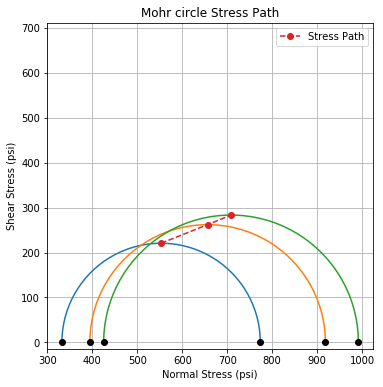

In [13]:
# Part g, Plot the stress path with Mohr circles for the initial 0.1 days and final time

# Let us get the effective stresses at all times
data2['Sigma n'] = data2['Total Normal Stress I'] - alpha*data2['Pore Pressure']
data2['Sigma v'] = data2['Total Normal Stress K'] - alpha*data2['Pore Pressure']

# Now we can visualize the stress path by plotting the Mohr's circle at a
# set of time steps t = [0.1 day, 50 days, 100 days]

# Mohr's circle plotting function
def mohrCircle(df,day,ax):
    
    for d,t in enumerate(df['TIME'].values):
        if t >= day:
            break

    a = df['Sigma n'].iloc[d]
    b = df['Sigma v'].iloc[d]
    
    circleX=[]
    circleY=[]

    for i in np.linspace(0,np.pi):
        circleX.append((b-a)/2*np.cos(i) + (a+(b-a)/2))
        circleY.append((b-a)/2*np.sin(i) )
    ax.plot(circleX,circleY)
    ax.plot([a,b],[0,0],'ko')
    p = [a+ (b-a)/2, (b-a)/2]
    return p
    

# Setup figure
fig,ax = plt.subplots(figsize=(6,6))
ax.grid()
ax.set_title("Mohr circle Stress Path")
ax.set_xlabel("Normal Stress (psi)")
ax.set_ylabel("Shear Stress (psi)")
p1 = mohrCircle(data2,0.1,ax)
p2 = mohrCircle(data2,50,ax)
p3 = mohrCircle(data2,100,ax)
px = [p1[0],p2[0],p3[0]]
py = [p1[1],p2[1],p3[1]]
ax.plot(px,py,'o--',label="Stress Path")
plt.axis("square")
ax.legend()

Day: 0.1 
P: 479.42 [psi]
Q: 441.56 [psi]
Day: 50 
P: 569.15 [psi]
Q: 524.3 [psi]
Day: 100 
P: 614.1 [psi]
Q: 567.0 [psi]


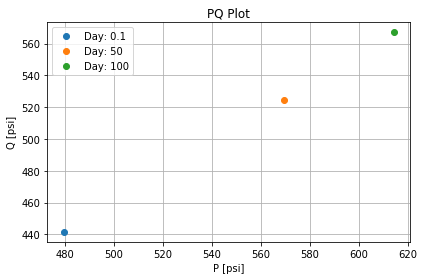

In [14]:
# Part h, Plot the stress path in the p'-q space for the same period of time
fig, ax = plt.subplots()
pqOutput = []
days = [0.1,50,100]
dayIdx = []
for entry in days:   
    for d,t in enumerate(data2['TIME'].values):
        if t >= entry:
            break
    #Save index for later
    dayIdx.append(d)

    a = data2['Sigma n'].iloc[d]
    b = data2['Sigma v'].iloc[d]
    c=a
    p = (a+b+c)/3
    q = np.sqrt(3*(1/6)*((a-b)**2+(b-c)**2+(a-c)**2))
    pqOutput.append("Day: " + str(entry) + " \nP: " + str(np.round(p,2)) +" [psi]\nQ: "+str(np.round(q,2))+" [psi]")
    ax.plot(p,q,'o',label='Day: '+str(entry))
    ax.grid()
    ax.set_xlabel('P [psi]')
    ax.set_ylabel('Q [psi]')
    ax.set_title("PQ Plot")

    plt.tight_layout()
ax.legend()
for item in pqOutput: print(item)

Text(0.5,1,'Stress Path')

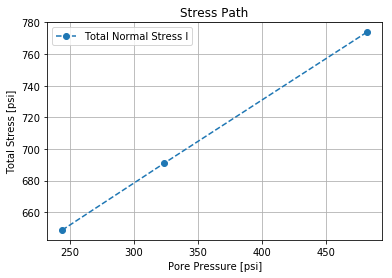

In [15]:
# Part i, Plot the stress path of total stress as a function of pore pressure
fig,ax = plt.subplots()
data2.iloc[dayIdx].plot(x='Pore Pressure',y='Total Normal Stress I',ax=ax,style='--o')
ax.set_xlabel("Pore Pressure [psi]")
ax.set_ylabel("Total Stress [psi]")
ax.grid()
ax.set_title("Stress Path")

In [16]:
# Part j, What would the minimum pressure to create a hydraulic fracture
# be at bottom hole pressure BHP = 240 psi? Compare with Analytical Solution

# Analytical Analysis says we must exceed Sigma22
minBHP = 240 # psi
Sv = 1200 # psi
v = 0.3

Sigma22 = (v/(1-v))*Sv + (1- (v/(1-v)))*alpha[0]*minBHP 
print("Analytical Solution says: ", np.round(Sigma22,2), '[psi]')

Analytical Solution says:  639.86 [psi]


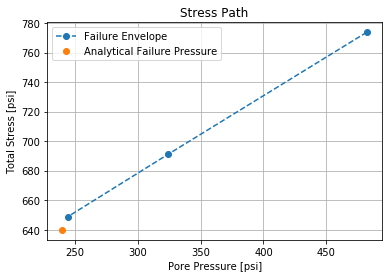

In [17]:
# Let us See where this falls compare to the simulation result
fig,ax = plt.subplots()
data2.iloc[dayIdx].plot(x='Pore Pressure',y='Total Normal Stress I',ax=ax,style='--o',label='Failure Envelope')
ax.set_xlabel("Pore Pressure [psi]")
ax.set_ylabel("Total Stress [psi]")
ax.grid()
ax.set_title("Stress Path")
ax.plot(minBHP,Sigma22, 'o',label='Analytical Failure Pressure')
ax.legend()

## The analytical prediction is slightly lower than the simulation result.